<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code</a></span></li><li><span><a href="#Configuration" data-toc-modified-id="Configuration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Fixed-Parameters" data-toc-modified-id="Fixed-Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fixed Parameters</a></span></li><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Loading Data</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimization</a></span></li><li><span><a href="#Today's-System-(6-kWc,-0-kWh)" data-toc-modified-id="Today's-System-(6-kWc,-0-kWh)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Today's System (6 kWc, 0 kWh)</a></span></li><li><span><a href="#Future-System-(9-kWc,-10-kWh)" data-toc-modified-id="Future-System-(9-kWc,-10-kWh)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Future System (9 kWc, 10 kWh)</a></span></li><li><span><a href="#Compare-Specific-Periods" data-toc-modified-id="Compare-Specific-Periods-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Compare Specific Periods</a></span></li></ul></div>

### Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
from itertools import product
from datetime import datetime

In [63]:
import matplotlib.pyplot as plt
import matplotlib.dates as pldt  # mdates
import matplotlib.patches as ptc
from pandas.tseries.offsets import MonthEnd

In [4]:
from PIL import Image
from IPython.display import display

### Code

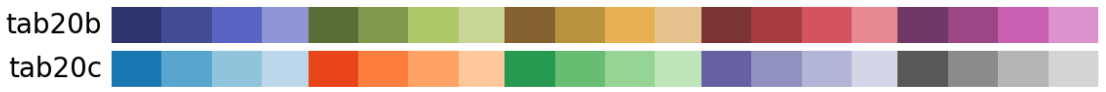

In [5]:
display(Image.open('tab20b and tab20c color maps.png'))

In [6]:
def get_tab_color(color_index, shade_index):
    """
    Get a color from the combined 'tab20b' and 'tab20c' colormaps.

    Parameters:
    color_index (int): Index of the color group, 0 to 9.
    shade_index (int): Index of the shade within the color group, 0 to 3.

    Returns:
    tuple: RGBA color tuple.
    """
    
    color_index = color_index % 10
    shade_index = shade_index % 4
    
    cmap_name = 'tab20b' if color_index < 5 else 'tab20c'
    cmap = plt.get_cmap(cmap_name)

    pos_in_map = (color_index % 5) * 4 + shade_index
    
    return cmap(np.arange(20, dtype=int))[pos_in_map]

In [7]:
def load_and_prepare_data(
    import_file,
    columns_map):
    
    df = pd.read_csv(import_file)

    # First, reverse the columns_map dictionary to map old names to new names
    reverse_columns_map = {v: k for k, v in columns_map.items()}

    # Now rename the columns using the reversed mapping
    df = df.rename(columns=reverse_columns_map)

    # Set Index
    df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%m/%d/%Y %H:%M')

    # Set the datetime column as the index
    df.set_index('time_stamp', inplace=True)

    # Ensure the index is sorted chronologically
    df.sort_index(inplace=True)
    
    return df

In [8]:
def rescale_solar_production(
    df_original,
    original_capacity,
    new_capacity):
    
    """
    Rescale solar production data from original PV capacity to new PV capacity.

    Assumptions:
    1. Solar production scales linearly with panel capacity
    2. Consumption remains the same
    3. Export is increased production minus any additional self-consumption
    4. Import is reduced by any additional self-consumption

    Parameters:
    df_original (pd.DataFrame): Original DataFrame with energy data
    original_capacity (float): Original solar capacity in kWc
    new_capacity (float): New solar capacity in kWc

    Returns:
    pd.DataFrame: New DataFrame with rescaled values
    """
    
    if original_capacity == new_capacity:
        return df_original.copy()
    
    # Make a copy of the original dataframe to avoid modifying it
    df = df_original.copy()

    # Calculate scaling factor
    scaling_factor = new_capacity / original_capacity

    # Rescale produced_wh (solar production scales directly with panel capacity)
    df['produced_wh'] = df['produced_wh'] * scaling_factor

    # Calculate how much additional energy is now produced
    additional_production = df['produced_wh'] - df_original['produced_wh']

    # Calculate how much of this additional production can be self-consumed
    # This is the minimum between additional production and what would have been imported
    potential_self_consumption = df_original['imported_wh']
    additional_self_consumption = np.minimum(additional_production, potential_self_consumption)

    # Calculate new values for imported_wh and exported_wh
    # Imported energy decreases by the additional self-consumption
    df['imported_wh'] = df_original['imported_wh'] - additional_self_consumption
    df['imported_wh'] = df['imported_wh'].clip(lower=0)  # Can't have negative imports

    # Exported energy is original export plus any additional production not self-consumed
    df['exported_wh'] = df_original['exported_wh'] + (additional_production - additional_self_consumption)

    # Consumed energy stays the same (assumption in the problem statement)
    # But let's verify that energy balance still makes sense
    # Total energy available = produced + imported (from grid)
    # Total energy used = consumed + exported (to grid)
    # The difference between these should be zero

    # Return the rescaled dataframe
    return df

In [9]:
def simulate_battery(
    df,
    max_battery_capacity_wh,
    battery_discharge_lower_limit_pc,
    battery_charge_upper_limit_pc,
    battery_efficiency_pc,
    max_battery_charge_rate_w,
    max_battery_discharge_rate_w,
    enable_hc_charging):
    
    """
    Simulate the addition of a battery to the solar panel system with updated charge/discharge logic and battery efficiency.
    This version focuses only on tracking energy flows between components.

    Parameters:
    - df: pandas DataFrame with columns produced_wh, consumed_wh, and time_stamp as the index.
    - max_battery_capacity_wh: Maximum capacity of the battery in Wh.
    - battery_discharge_lower_limit_pc: Minimum SOC percentage (0-25).
    - battery_charge_upper_limit_pc: Maximum SOC percentage (75-100).
    - battery_efficiency_pc: Battery round-trip efficiency percentage (0-100).
    - max_battery_charge_rate_w: Maximum charge rate in watts.
    - max_battery_discharge_rate_w: Maximum discharge rate in watts.
    - enable_hc_charging: Boolean flag to enable/disable battery charging from grid during HC periods.

    Returns:
    - df_with_battery: DataFrame with columns tracking energy flows between components.
    """
    # Validate parameters
    if not (0 <= battery_discharge_lower_limit_pc <= 25):
        raise ValueError("battery_discharge_lower_limit_pc must be between 0 and 25")
    if not (75 <= battery_charge_upper_limit_pc <= 100):
        raise ValueError("battery_charge_upper_limit_pc must be between 75 and 100")
    if not (0 <= battery_efficiency_pc <= 100):
        raise ValueError("battery_efficiency_pc must be between 0 and 100")

    # Calculate battery limits in Wh
    battery_discharge_lower_limit_wh = max_battery_capacity_wh * battery_discharge_lower_limit_pc / 100
    battery_charge_upper_limit_wh = max_battery_capacity_wh * battery_charge_upper_limit_pc / 100

    # Initialize battery parameters
    if max_battery_charge_rate_w is None:
        max_battery_charge_rate_w = 2 * max_battery_capacity_wh / 3
        
    if max_battery_discharge_rate_w is None:
        max_battery_discharge_rate_w = 2 * max_battery_capacity_wh / 3

    max_charge_rate_wh = max_battery_charge_rate_w / 4  # Convert to Wh per 15 minutes
    max_discharge_rate_wh = max_battery_discharge_rate_w / 4  # Convert to Wh per 15 minutes

    # Make a copy of the dataframe to avoid modifying the original
    df = df.copy()

    # Add columns to store the energy flow results
    df['Grid > House'] = 0.0
    df['Grid > Battery'] = 0.0
    df['Solar > House'] = 0.0
    df['Battery > House'] = 0.0
    df['Solar > Battery'] = 0.0
    df['Solar > Grid'] = 0.0
    df['Battery SOC'] = 0.0

    # Initialize battery state
    battery_soc = 0

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        
        time_stamp = index
        produced_wh = row['produced_wh']
        consumed_wh = row['consumed_wh']

        # Determine if the current time is HP or HC
        hour = time_stamp.hour
        is_high_price = 7 <= hour < 23  # HP from 7:00 to 23:00

        # Initialize energy flow variables for this time period
        grid_to_house = 0
        grid_to_battery = 0
        solar_to_house = 0
        battery_to_house = 0
        solar_to_battery = 0
        solar_to_grid = 0

        # Calculate Solar > House (direct solar consumption)
        solar_to_house = min(produced_wh, consumed_wh)

        # Calculate net energy (what's left after solar directly powers house)
        net_energy = produced_wh - consumed_wh

        # Case 1: Deficit (solar production < consumption)
        if net_energy < 0:
            
            energy_needed = -net_energy

            # Try to cover deficit with battery discharge (Battery > House)
            available_energy = max(0, battery_soc - battery_discharge_lower_limit_wh)
            potential_discharge = min(energy_needed, max_discharge_rate_wh, available_energy)

            if potential_discharge > 0:
                soc_decrease = potential_discharge / (battery_efficiency_pc / 100)
                battery_to_house = potential_discharge
                battery_soc -= soc_decrease
                remaining_deficit = energy_needed - potential_discharge
            else:
                remaining_deficit = energy_needed

            # Any remaining deficit comes from grid to house (Grid > House)
            if remaining_deficit > 0:
                
                grid_to_house = remaining_deficit

        # Case 2: Excess (solar production > consumption)
        elif net_energy > 0:
            
            # Use excess to charge battery (Solar > Battery)
            max_possible_charge = min(net_energy, max_charge_rate_wh)
            space_available = battery_charge_upper_limit_wh - battery_soc

            if space_available <= 0:
                potential_charge = 0
            else:
                potential_charge = min(max_possible_charge, space_available)

            if potential_charge > 0:
                
                soc_increase = potential_charge * battery_efficiency_pc / 100
                solar_to_battery = potential_charge
                battery_soc += soc_increase

                # Remaining excess is exported to the grid (Solar > Grid)
                remaining_excess = net_energy - potential_charge
                
                if remaining_excess > 0:
                    solar_to_grid = remaining_excess
            else:
                # If no battery charging, all excess goes to grid
                solar_to_grid = net_energy

        # Clamp battery SOC after solar operations but before grid charging
        battery_soc = max(0, min(battery_soc, max_battery_capacity_wh))
        battery_soc = max(battery_discharge_lower_limit_wh, min(battery_soc, battery_charge_upper_limit_wh))

        # In HC periods, if enabled, charge from grid if there's room (Grid > Battery)
        if not is_high_price and enable_hc_charging:
            
            space_available = battery_charge_upper_limit_wh - battery_soc
            
            if space_available > 0:
                
                max_possible_charge = min(space_available, max_charge_rate_wh)
                
                if max_possible_charge > 0:
                    
                    soc_increase = max_possible_charge * battery_efficiency_pc / 100
                    grid_to_battery = max_possible_charge
                    battery_soc += soc_increase

        # Final clamp (for safety, though theoretically not needed now)
        battery_soc = max(0, min(battery_soc, max_battery_capacity_wh))
        battery_soc = max(battery_discharge_lower_limit_wh, min(battery_soc, battery_charge_upper_limit_wh))

        # Update the DataFrame with the energy flow results
        df.at[index, 'Grid > House'] = grid_to_house
        df.at[index, 'Grid > Battery'] = grid_to_battery
        df.at[index, 'Solar > House'] = solar_to_house
        df.at[index, 'Battery > House'] = battery_to_house
        df.at[index, 'Solar > Battery'] = solar_to_battery
        df.at[index, 'Solar > Grid'] = solar_to_grid
        df.at[index, 'Battery SOC'] = battery_soc

    return df

In [10]:
def optimize_capacity(
    df,
    wh_price_sale_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    subscription_monthly_fee_eur,
    original_solar_capacity,
    solar_capacities_w,
    battery_capacities_wh,
    battery_discharge_lower_limit_pc,
    battery_charge_upper_limit_pc,
    battery_efficiency_pc,
    enable_hc_charging):

    results = []

    for solar_capacity, battery_capacity in product(solar_capacities_w, battery_capacities_wh):
        
        # Rescale solar production
        scaled_df = rescale_solar_production(
            df,
            original_solar_capacity,
            solar_capacity)

        simulated_df = simulate_battery(
            scaled_df,
            battery_capacity,
            battery_discharge_lower_limit_pc,
            battery_charge_upper_limit_pc,
            battery_efficiency_pc,
            max_battery_charge_rate_w=None,
            max_battery_discharge_rate_w=None,
            enable_hc_charging=enable_hc_charging,
        )
        
        result = {
            'solar_capacity': solar_capacity,
            'battery_capacity': battery_capacity,
            'data': simulated_df,
        }
        
        results.append(result)

        if DEBUG:
            print(f'--------------------------------------------------------------------')
            print(f'solar       -> {int(solar_capacity/1000.0)}kWc')
            print(f'battery     -> {int(battery_capacity/1000.0)}kWh')
            print(f'HC charging -> {enable_hc_charging}')
            print(f'--------------------------------------------------------------------')
            print(f'')
            print(f'')

    return results

In [11]:
def format_wh(first, second=None):
    
    if first is None:
        return None

    if second is None:
        return round(first / 1000, 2)

    return round((first + second) / 1000, 2)

In [12]:
def calculate_cost(
    row,
    category,
    wh_column,
    results,
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur):
    
    wh = abs(row[wh_column])

    if wh == 0:
        return

    if category == 'Solar > Grid':
        # This is income from selling solar, so negative cost
        cost = wh * wh_price_sale_eur * -1

        if row['is_hp']:
            results[category]['hp_cost'] += cost
            results[category]['hp_wh'] += wh
        else:
            results[category]['hc_cost'] += cost
            results[category]['hc_wh'] += wh

    elif category == 'Solar > Battery':
        # Cost of storing solar instead of selling it
        cost = wh * wh_price_sale_eur  # Positive cost since we're not selling

        if row['is_hp']:
            results[category]['hp_cost'] += cost
            results[category]['hp_wh'] += wh
        else:
            results[category]['hc_cost'] += cost
            results[category]['hc_wh'] += wh

    elif category in ['Grid > House', 'Grid > Battery']:
        if row['is_hp']:
            rate = wh_price_high_eur
            period = 'hp'
        else:
            rate = wh_price_low_eur
            period = 'hc'

        cost = wh * rate

        results[category][f'{period}_cost'] += cost
        results[category][f'{period}_wh'] += wh

    elif category == 'Battery > House':
        if row['is_hp']:
            rate = wh_price_high_eur
            period = 'hp'
        else:
            rate = wh_price_low_eur
            period = 'hc'

        cost = wh * rate * -1

        results[category][f'{period}_cost'] += cost
        results[category][f'{period}_wh'] += wh

    elif category == 'Solar > House':
        if row['is_hp']:
            rate = wh_price_high_eur
            period = 'hp'
        else:
            rate = wh_price_low_eur
            period = 'hc'

        cost = wh * rate * -1

        results[category][f'{period}_cost'] += cost
        results[category][f'{period}_wh'] += wh

In [13]:
def filter_data(
    df,
    start_date,
    end_date):
    
    """
    Filter input data.

    Parameters:
    - df: DataFrame containing the battery data.
    - start_date: Start date for the data range.
    - end_date: End date for the data range.

    Returns:
    - filtered_df: Filtered DataFrame based on the date range.
    """
    
    # Convert start_date and end_date to datetime objects
    try:
        start_date = pd.Timestamp(datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S"))
    except ValueError:
        start_date = pd.Timestamp(datetime.strptime(start_date, "%Y-%m-%d"))
        
    try:
        end_date = pd.Timestamp(datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S"))
    except ValueError:
        end_date = pd.Timestamp(datetime.strptime(end_date, "%Y-%m-%d"))

    # Filter the DataFrame to include only rows within the date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask].copy()

    # Determine HP/HC periods
    hours = filtered_df.index.hour
    filtered_df['is_hp'] = (hours >= 7) & (hours < 23)
    filtered_df['is_hc'] = ~filtered_df['is_hp']

    return filtered_df    

In [14]:
def process_battery_data(
    df,
    start_date,
    end_date,
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    subscription_monthly_fee_eur):
    
    """
    Process battery data and calculate various metrics and costs.

    Parameters:
    - df: DataFrame containing the battery data.
    - start_date: Start date for the data range.
    - end_date: End date for the data range.
    - wh_price_high_eur: Price per Wh during high period.
    - wh_price_low_eur: Price per Wh during low period.
    - wh_price_sale_eur: Price per Wh for selling energy back to the grid.
    - subscription_monthly_fee_eur: Monthly subscription fee.

    Returns:
    - results_df: DataFrame containing the calculated metrics and totals.
    """

    filtered_df = filter_data(df, start_date, end_date)

    # Calculate fixed cost per interval
    num_intervals = len(filtered_df)
    if num_intervals > 0:
        fixed_cost_per_interval = (12 * subscription_monthly_fee_eur) / (365 * 24 * 4)
    else:
        fixed_cost_per_interval = 0

    # Initialize results dictionary with all categories with updated names
    results = {
        'Grid > House': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Battery > House': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Solar > Grid': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Grid > Battery': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Solar > House': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Solar > Battery': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Solar Savings': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Battery Savings': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0},
        'Subscription Fee': {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0}
    }

    # Process each row to accumulate the totals
    for _, row in filtered_df.iterrows():
        calculate_cost(row, 'Grid > House', 'Grid > House', results, wh_price_high_eur, wh_price_low_eur, wh_price_sale_eur)
        calculate_cost(row, 'Battery > House', 'Battery > House', results, wh_price_high_eur, wh_price_low_eur, wh_price_sale_eur)
        calculate_cost(row, 'Solar > Grid', 'Solar > Grid', results, wh_price_high_eur, wh_price_low_eur, wh_price_sale_eur)
        calculate_cost(row, 'Grid > Battery', 'Grid > Battery', results, wh_price_high_eur, wh_price_low_eur, wh_price_sale_eur)
        calculate_cost(row, 'Solar > House', 'Solar > House', results, wh_price_high_eur, wh_price_low_eur, wh_price_sale_eur)

        # Handle solar charge separately (already handled in the above line)
        wh = row['Solar > Battery']
        if wh > 0:
            if row['is_hp']:
                period = 'hp'
            else:
                period = 'hc'
            results['Solar > Battery'][f'{period}_wh'] += wh
            cost = wh * wh_price_sale_eur  # Cost of not selling this energy
            results['Solar > Battery'][f'{period}_cost'] += cost

    # Calculate fixed costs
    if num_intervals > 0:
        total_fixed_cost = fixed_cost_per_interval * num_intervals
        num_hp_intervals = filtered_df['is_hp'].sum()
        num_hc_intervals = num_intervals - num_hp_intervals
        if num_hp_intervals > 0:
            results['Subscription Fee']['hp_cost'] = (total_fixed_cost * num_hp_intervals) / num_intervals
        if num_hc_intervals > 0:
            results['Subscription Fee']['hc_cost'] = (total_fixed_cost * num_hc_intervals) / num_intervals

    # Calculate savings correctly
    # Reset savings calculations
    results['Solar Savings'] = {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0}
    results['Battery Savings'] = {'hp_cost': 0, 'hp_wh': 0, 'hc_cost': 0, 'hc_wh': 0}

    # Calculate Solar Savings: "Solar > Grid" + "Solar > House" + "Solar > Battery"
    for period in ['hp', 'hc']:
        solar_to_grid = results['Solar > Grid'][f'{period}_cost']
        solar_to_house = results['Solar > House'][f'{period}_cost']
        solar_to_battery = results['Solar > Battery'][f'{period}_cost']
        total_cost = solar_to_grid + solar_to_house + solar_to_battery
        total_wh = None
        results['Solar Savings'][f'{period}_cost'] = total_cost
        results['Solar Savings'][f'{period}_wh'] = total_wh

    # Calculate Battery Savings: "Battery > House" - "Solar > Battery" + "Grid > Battery"
    for period in ['hp', 'hc']:
        battery_to_house = results['Battery > House'][f'{period}_cost']
        solar_to_battery = results['Solar > Battery'][f'{period}_cost']
        grid_to_battery = results['Grid > Battery'][f'{period}_cost']
        # Total battery savings is the sum of these components
        total_cost = battery_to_house - solar_to_battery + grid_to_battery
        total_wh = None

        results['Battery Savings'][f'{period}_cost'] = total_cost
        results['Battery Savings'][f'{period}_wh'] = total_wh

    # Calculate totals
    # 0. Total Raw Consumed
    total_consumed_naked_hp_wh = (results['Grid > House']['hp_wh'] +
                           results['Solar > House']['hp_wh'] +
                           results['Battery > House']['hp_wh'])
    total_consumed_naked_hc_wh = (results['Grid > House']['hc_wh'] +
                           results['Solar > House']['hc_wh'] +
                           results['Battery > House']['hc_wh'])
    total_consumed_naked_hp_cost = total_consumed_naked_hp_wh * wh_price_high_eur
    total_consumed_naked_hc_cost = total_consumed_naked_hc_wh * wh_price_low_eur

    # 1. Total Consumed (Any > House)
    total_consumed_hp_wh = (results['Grid > House']['hp_wh'] +
                           results['Solar > House']['hp_wh'] +
                           results['Battery > House']['hp_wh'])
    total_consumed_hc_wh = (results['Grid > House']['hc_wh'] +
                           results['Solar > House']['hc_wh'] +
                           results['Battery > House']['hc_wh'])
    total_consumed_hp_cost = (results['Grid > House']['hp_cost'] +
                             results['Solar > House']['hp_cost'] +
                             results['Battery > House']['hp_cost'])
    total_consumed_hc_cost = (results['Grid > House']['hc_cost'] +
                             results['Solar > House']['hc_cost'] +
                             results['Battery > House']['hc_cost'])

    # 2. Total Stored (Any > Battery)
    total_stored_hp_wh = (results['Grid > Battery']['hp_wh'] +
                         results['Solar > Battery']['hp_wh'])
    total_stored_hc_wh = (results['Grid > Battery']['hc_wh'] +
                         results['Solar > Battery']['hc_wh'])
    total_stored_hp_cost = (results['Grid > Battery']['hp_cost'] +
                           results['Solar > Battery']['hp_cost'])
    total_stored_hc_cost = (results['Grid > Battery']['hc_cost'] +
                           results['Solar > Battery']['hc_cost'])

    # 3. Total Produced (Solar > Any)
    total_produced_hp_wh = (results['Solar > Battery']['hp_wh'] +
                           results['Solar > Grid']['hp_wh'] +
                           results['Solar > House']['hp_wh'])
    total_produced_hc_wh = (results['Solar > Battery']['hc_wh'] +
                           results['Solar > Grid']['hc_wh'] +
                           results['Solar > House']['hc_wh'])
    total_produced_hp_cost = (results['Solar > Battery']['hp_cost'] +
                             results['Solar > Grid']['hp_cost'] +
                             results['Solar > House']['hp_cost'])
    total_produced_hc_cost = (results['Solar > Battery']['hc_cost'] +
                             results['Solar > Grid']['hc_cost'] +
                             results['Solar > House']['hc_cost'])

    # 4. Total Imported (Grid > Any)
    total_imported_hp_wh = (results['Grid > House']['hp_wh'] +
                           results['Grid > Battery']['hp_wh'])
    total_imported_hc_wh = (results['Grid > House']['hc_wh'] +
                           results['Grid > Battery']['hc_wh'])
    total_imported_hp_cost = (results['Grid > House']['hp_cost'] +
                             results['Grid > Battery']['hp_cost'])
    total_imported_hc_cost = (results['Grid > House']['hc_cost'] +
                             results['Grid > Battery']['hc_cost'])

    # 5. All Savings (sum of both savings)
    all_savings_hp_cost = results['Solar Savings']['hp_cost'] + results['Battery Savings']['hp_cost']
    all_savings_hc_cost = results['Solar Savings']['hc_cost'] + results['Battery Savings']['hc_cost']
    all_savings_hp_wh = None
    all_savings_hc_wh = None

    # Add our new totals
    total_exported_hp_wh = results['Solar > Grid']['hp_wh']
    total_exported_hc_wh = results['Solar > Grid']['hc_wh']
    total_exported_hp_cost = results['Solar > Grid']['hp_cost']
    total_exported_hc_cost = results['Solar > Grid']['hc_cost']
    total_cost_hp_cost = (total_imported_hp_cost +
                         results['Subscription Fee']['hp_cost'] +
                         total_exported_hp_cost)
    total_cost_hc_cost = (total_imported_hc_cost +
                         results['Subscription Fee']['hc_cost'] +
                         total_exported_hc_cost)
    total_cost_hp_wh = None
    total_cost_hc_wh = None
    total_cost_naked_hp_cost = total_consumed_naked_hp_cost + results['Subscription Fee']['hp_cost']
    total_cost_naked_hc_cost = total_consumed_naked_hc_cost + results['Subscription Fee']['hc_cost']
    total_cost_naked_hp_wh = None
    total_cost_naked_hc_wh = None

    # Add totals and savings to results
    results.update({
        'Total Consumed (Naked)': {
            'hp_cost': total_consumed_naked_hp_cost,
            'hp_wh': total_consumed_naked_hp_wh,
            'hc_cost': total_consumed_naked_hc_cost,
            'hc_wh': total_consumed_naked_hc_wh
        },
        'Total Consumed (Any > House)': {
            'hp_cost': total_consumed_hp_cost,
            'hp_wh': total_consumed_hp_wh,
            'hc_cost': total_consumed_hc_cost,
            'hc_wh': total_consumed_hc_wh
        },
        'Total Stored (Any > Battery)': {
            'hp_cost': total_stored_hp_cost,
            'hp_wh': total_stored_hp_wh,
            'hc_cost': total_stored_hc_cost,
            'hc_wh': total_stored_hc_wh
        },
        'Total Produced (Solar > Any)': {
            'hp_cost': total_produced_hp_cost,
            'hp_wh': total_produced_hp_wh,
            'hc_cost': total_produced_hc_cost,
            'hc_wh': total_produced_hc_wh
        },
        'Total Imported (Grid > Any)': {
            'hp_cost': total_imported_hp_cost,
            'hp_wh': total_imported_hp_wh,
            'hc_cost': total_imported_hc_cost,
            'hc_wh': total_imported_hc_wh
        },
        'Total Exported (Any > Grid)': {
            'hp_cost': total_exported_hp_cost,
            'hp_wh': total_exported_hp_wh,
            'hc_cost': total_exported_hc_cost,
            'hc_wh': total_exported_hc_wh
        },
        'Total Cost': {
            'hp_cost': total_cost_hp_cost,
            'hp_wh': total_cost_hp_wh,
            'hc_cost': total_cost_hc_cost,
            'hc_wh': total_cost_hc_wh
        },
        'Total Cost (Naked)': {
            'hp_cost': total_cost_naked_hp_cost,
            'hp_wh': total_cost_naked_hp_wh,
            'hc_cost': total_cost_naked_hc_cost,
            'hc_wh': total_cost_naked_hc_wh
        },
        'All Savings': {
            'hp_cost': all_savings_hp_cost,
            'hp_wh': all_savings_hp_wh,
            'hc_cost': all_savings_hc_cost,
            'hc_wh': all_savings_hc_wh
        }
    })


    # Create lists to build the DataFrame with hierarchical index
    data = []
    # Metrics section
    metric_order = [
        'Grid > House',
        'Grid > Battery',
        'Solar > House',
        'Battery > House',
        'Solar > Battery',
        'Solar > Grid',
        'Subscription Fee'
    ]
    for name in metric_order:
        if name in results:
            item = results[name]
            data.append({
                'Category': 'Metric',
                'Type': name,
                'HP Cost': round(item['hp_cost'], 2),
                'HP kWh': format_wh(item['hp_wh']),
                'HC Cost': round(item['hc_cost'], 2),
                'HC kWh': format_wh(item['hc_wh']),
                'Total Cost': round(item['hp_cost'] + item['hc_cost'], 2),
                'Total kWh': format_wh(item['hp_wh'], item['hc_wh'])
            })
    # Totals section
    totals_order = [
        'Total Imported (Grid > Any)',
        'Total Exported (Any > Grid)',
        'Total Stored (Any > Battery)',
        'Total Produced (Solar > Any)',
        'Total Consumed (Any > House)',
        'Total Consumed (Naked)',
        'Total Cost',
        'Total Cost (Naked)'
    ]
    for name in totals_order:
        if name in results:
            item = results[name]
            data.append({
                'Category': 'Total',
                'Type': name,
                'HP Cost': round(item['hp_cost'], 2),
                'HP kWh': format_wh(item['hp_wh']),
                'HC Cost': round(item['hc_cost'], 2),
                'HC kWh': format_wh(item['hc_wh']),
                'Total Cost': round(item['hp_cost'] + item['hc_cost'], 2),
                'Total kWh': format_wh(item['hp_wh'], item['hc_wh'])
            })
    # Savings section
    savings_order = ['Solar Savings', 'Battery Savings', 'All Savings']
    for name in savings_order:
        if name in results:
            item = results[name]
            data.append({
                'Category': 'Savings',
                'Type': name,
                'HP Cost': round(item['hp_cost'], 2),
                'HP kWh': format_wh(item['hp_wh']),
                'HC Cost': round(item['hc_cost'], 2),
                'HC kWh': format_wh(item['hc_wh']),
                'Total Cost': round(item['hp_cost'] + item['hc_cost'], 2),
                'Total kWh': format_wh(item['hp_wh'], item['hc_wh'])
            })

    # Create DataFrame and set hierarchical index
    results_df = pd.DataFrame(data)
    results_df = results_df.set_index(['Category', 'Type'])
    # Sort the index to have Metrics first, then Totals, then Savings
    results_df = results_df.sort_index(level=0, sort_remaining=False)

    return results_df

In [15]:
def plot_battery_soc_chart(
    df,
    start_date,
    end_date,
    y_min=None,
    y_max=None):

    """
    Plot the battery SOC and charging/discharging activities over a specified time period.
    Parameters:
    - df: DataFrame containing the battery data.
    - start_date: Start date for the data range.
    - end_date: End date for the data range.
    """
    
    filtered_df = filter_data(df, start_date, end_date)
    
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Plot the SOC level with updated style
    ax.plot(
        filtered_df.index,
        filtered_df['Battery SOC'],
        label='Battery SOC',
        color=get_tab_color(9, 1),  # 'darkgrey'
        linestyle=':',
        linewidth=1.5)
    
    # Plot the total consumption line (this might need adjustment)
    ax.plot(
        filtered_df.index,
        filtered_df['consumed_wh'] * 4,
        label='Consumed',
        color=get_tab_color(9, 1),  # 'darkgrey'
        linewidth=1.5)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Energy (Wh)')
    ax.set_title('Energy Flows and Battery SOC')
    ax.grid(True)
    
    # Add vertical bands for HC periods
    timestamps = filtered_df.index.to_pydatetime()
    is_hc = filtered_df['is_hc'].tolist()
    hc_ranges = []
    current_range_start = None
    
    for i in range(len(timestamps)):
        if is_hc[i]:
            if current_range_start is None:
                current_range_start = timestamps[i]
        else:
            if current_range_start is not None:
                hc_ranges.append((current_range_start, timestamps[i-1]))
                current_range_start = None
                
    if current_range_start is not None:
        hc_ranges.append((current_range_start, timestamps[-1]))
        
    for start, end in hc_ranges:
        ax.axvspan(
            start, 
            end,
            color=get_tab_color(9, 3),  # 'lightgrey'
            alpha=0.3,
            linewidth=0)
        
    # Define the width of the bars
    width = 0.01
    
    # Plot positive bars (stacking up)
    
    # 1. Grid > House (replaces grid_consumed_wh)
    ax.bar(
        filtered_df.index,
        filtered_df['Grid > House'] * 4,
        width=width,
        color=get_tab_color(5, 2),  # 'lightblue'
        label='Grid > House',
        alpha=0.7)
    
    bottom = filtered_df['Grid > House'] * 4
    
    
    # 2. Grid > Battery (replaces battery_charge_grid_wh)
    ax.bar(
        filtered_df.index,
        filtered_df['Grid > Battery'] * 4,
        width=width,
        color=get_tab_color(5, 1),  # 'blue'
        label='Grid > Battery',
        alpha=0.7,
        bottom=bottom)
    
    bottom += filtered_df['Grid > Battery'] * 4
    
    
    # 3. Solar > House (replaces solar_consumed_wh)
    ax.bar(
        filtered_df.index,
        filtered_df['Solar > House'] * 4,
        width=width,
        color=get_tab_color(7, 3),  # 'lightgreen',
        label='Solar > House',
        alpha=0.7,
        bottom=bottom)
    
    bottom += filtered_df['Solar > House'] * 4
    
    
    # 4. Battery > House (replaces battery_discharge_wh)
    ax.bar(
        filtered_df.index,
        filtered_df['Battery > House'] * 4,
        width=width,
        color=get_tab_color(6, 2),  # 'lightcoral',
        label='Battery > House',
        alpha=0.7,
        bottom=bottom)

    
    # Calculate Solar Excess (Solar > Battery + Solar > Grid)
    solar_excess = filtered_df['Solar > Battery'] + filtered_df['Solar > Grid']

    # Plot Solar Excess line (negative since both components are negative)
    ax.plot(
        filtered_df.index,
        -solar_excess * 4,
        label='Solar Excess',
        color=get_tab_color(9, 1),  # 'darkgrey'
        linewidth=1.5,
        linestyle='-')

    
    # Plot negative bars (stacking down)
    
    # 1. Solar > Battery (replaces battery_charge_solar_wh)
    ax.bar(
        filtered_df.index,
        -filtered_df['Solar > Battery'] * 4,
        width=width,
        color=get_tab_color(7, 2),  # 'lightgreen'
        label='Solar > Battery',
        alpha=0.7)

    
    # 2. Solar > Grid (replaces solar_exported_wh)
    ax.bar(
        filtered_df.index,
        -filtered_df['Solar > Grid'] * 4,
        width=width,
        color=get_tab_color(8, 2),  # 'lightsalmon'
        label='Solar > Grid',
        alpha=0.7,
        bottom=-filtered_df['Solar > Battery'] * 4)

    
    # Set up x-axis formatting with major and minor ticks
    ax.xaxis.set_major_locator(pldt.DayLocator())
    ax.xaxis.set_major_formatter(pldt.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_minor_locator(pldt.HourLocator(interval=3))
    ax.xaxis.set_minor_formatter(pldt.DateFormatter("%H:%M"))
    plt.xticks(rotation=45, ha='right')
    ax.tick_params(which='major', length=8, labelsize=10)
    ax.tick_params(which='minor', length=4, labelsize=8, color='gray')

    # Set y-axis limits if provided
    if y_min is not None and y_max is not None:
        ax.set_ylim(y_min, y_max)

    legend_elements = ax.get_legend_handles_labels()
    handles = legend_elements[0]
    labels = legend_elements[1]
    handles.append(ptc.Patch(facecolor='lightgrey', alpha=0.3, linewidth=0))
    labels.append('HC Periods')
    
    ax.legend(handles, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [70]:
def plot_battery_soc_chart_v2(
    df,
    start_date,
    end_date,
    y_min=None,
    y_max=None,
    cumulative_metrics=None,
    reset_freq=None):
    filtered_df = filter_data(df, start_date, end_date)
    # Calculate HC ranges if the column exists (do this once at the beginning)
    hc_ranges = None
    if 'is_hc' in filtered_df.columns:
        timestamps = filtered_df.index.to_pydatetime()
        is_hc = filtered_df['is_hc'].tolist()
        hc_ranges = []
        current_range_start = None
        for i in range(len(timestamps)):
            if is_hc[i]:
                if current_range_start is None:
                    current_range_start = timestamps[i]
            else:
                if current_range_start is not None:
                    hc_ranges.append((current_range_start, timestamps[i-1]))
                    current_range_start = None
        if current_range_start is not None:
            hc_ranges.append((current_range_start, timestamps[-1]))
    # Define all possible metrics and their corresponding colors
    all_metrics = [
        "Grid > House",
        "Grid > Battery",
        "Solar > House",
        "Battery > House",
        "Solar > Battery",
        "Solar > Grid"
    ]
    metric_colors = {
        "Grid > House": (5, 2),
        "Grid > Battery": (5, 1),
        "Solar > House": (7, 3),
        "Battery > House": (6, 2),
        "Solar > Battery": (7, 2),
        "Solar > Grid": (8, 2)
    }
    # Determine which metrics to plot
    if cumulative_metrics is None:
        cumulative_metrics = all_metrics
    elif not cumulative_metrics:  # if empty list
        cumulative_metrics = []
    else:
        # Ensure all requested metrics are valid
        cumulative_metrics = [m for m in cumulative_metrics if m in all_metrics]
    # Calculate bar width based on time differences
    if len(filtered_df.index) > 1:
        time_diff = np.diff(pldt.date2num(filtered_df.index))
        width = np.min(time_diff) * 0.8  # 80% of smallest interval
    else:
        width = 0.01  # default if only one data point
    # Step 1: Identify metrics with data and calculate cumulative values
    metrics_with_data = []
    all_cumulative_values = []
    all_reset_points = []
    for metric in cumulative_metrics:
        if metric not in filtered_df.columns:
            continue
        if reset_freq is None:
            cumulative_values = filtered_df[metric].cumsum() * 4
            reset_points = [len(filtered_df) - 1]  # just the last point (as integer position)
        else:
            if reset_freq == "day":
                groupby_col = filtered_df.index.date
            elif reset_freq == "HC/HP":
                if 'is_hc' not in filtered_df.columns:
                    continue
                groupby_col = (filtered_df['is_hc'] != filtered_df['is_hc'].shift(1)).cumsum()
            elif reset_freq == "week":
                groupby_col = filtered_df.index.isocalendar().week + filtered_df.index.isocalendar().year * 100
            elif reset_freq == "month":
                groupby_col = filtered_df.index.year * 12 + filtered_df.index.month
            else:
                raise ValueError(f"Unknown reset_freq: {reset_freq}")
            cumulative_values = filtered_df.groupby(groupby_col)[metric].cumsum() * 4
            # Find reset points (last integer position of each group)
            reset_points = []
            for group in groupby_col.unique():
                group_mask = (groupby_col == group)
                group_positions = np.where(group_mask)[0]  # Get integer positions
                if len(group_positions) > 0:
                    reset_points.append(group_positions[-1])
            # Add the last position if not already included
            if (len(filtered_df) - 1) not in reset_points:
                reset_points.append(len(filtered_df) - 1)
        # Check if there's any non-zero, non-NaN data
        has_data = (not cumulative_values.isna().all()) and (np.abs(cumulative_values) > 1e-6).any()
        if has_data:
            metrics_with_data.append(metric)
            all_cumulative_values.append(cumulative_values)
            all_reset_points.append(reset_points)
    num_cumulative_plots = len(metrics_with_data)
    # Calculate global min/max for cumulative plots if we have any metrics with data
    if num_cumulative_plots > 0:
        all_values = []
        for cv in all_cumulative_values:
            vals = cv.dropna().values
            if len(vals) > 0:
                all_values.extend(vals)
        if len(all_values) > 0:
            global_min = np.min(all_values) / 1000  # convert to kWh
            global_max = np.max(all_values) / 1000
            # Add padding (minimum 0.1 to ensure some range)
            y_padding = max(0.1, (global_max - global_min) * 0.1)
            global_min -= y_padding
            global_max += y_padding
        else:
            global_min, global_max = 0, 1
    else:
        global_min, global_max = 0, 1
    # Calculate the figure height
    if num_cumulative_plots == 0:
        fig_height = 10
    else:
        fig_height = 10 + num_cumulative_plots * 2.5
    # Create figure with constrained layout to avoid tight_layout warning
    fig = plt.figure(figsize=(16, fig_height), constrained_layout=True)
    # Create gridspec
    if num_cumulative_plots == 0:
        gs = fig.add_gridspec(1, 1)
        ax = fig.add_subplot(gs[0, 0])
    else:
        gs = fig.add_gridspec(
            nrows=1 + num_cumulative_plots,
            ncols=1,
            height_ratios=[10] + [2.5] * num_cumulative_plots,
            hspace=0.3
        )
        ax = fig.add_subplot(gs[0, 0])
    # Plot the main chart on ax (now converting to kWh where appropriate)
    if 'Battery SOC' in filtered_df.columns:
        ax.plot(
            filtered_df.index,
            filtered_df['Battery SOC'] / 1000,  # convert to kWh
            label='Battery SOC',
            color=get_tab_color(9, 1),
            linestyle=':',
            linewidth=1.5)
    if 'consumed_wh' in filtered_df.columns:
        ax.plot(
            filtered_df.index,
            filtered_df['consumed_wh'] * 4 / 1000,  # convert to kWh
            label='Consumed',
            color=get_tab_color(9, 1),
            linewidth=1.5)
#    ax.set_xlabel('Time')
    ax.set_ylabel('Energy (kWh)')
    ax.set_title('Energy Flows & Battery SOC')
    ax.grid(True)
    # Add vertical bands for HC periods if column exists
    if hc_ranges is not None:
        for start, end in hc_ranges:
            ax.axvspan(
                start,
                end,
                color=get_tab_color(9, 3),
                alpha=0.3,
                linewidth=0)
    # Initialize bottom for stacked bars
    bottom_pos = np.zeros(len(filtered_df))
    # Plot positive bars with kWh conversion
    if 'Grid > House' in filtered_df.columns:
        bars = ax.bar(
            filtered_df.index,
            filtered_df['Grid > House'] * 4 / 1000,  # convert to kWh
            width=width,
            color=get_tab_color(5, 2),
            label='Grid > House',
            alpha=0.7)
        bottom_pos = filtered_df['Grid > House'] * 4 / 1000
    if 'Grid > Battery' in filtered_df.columns and 'Grid > House' in filtered_df.columns:
        ax.bar(
            filtered_df.index,
            filtered_df['Grid > Battery'] * 4 / 1000,  # convert to kWh
            width=width,
            color=get_tab_color(5, 1),
            label='Grid > Battery',
            alpha=0.7,
            bottom=bottom_pos)
        bottom_pos += filtered_df['Grid > Battery'] * 4 / 1000
    elif 'Grid > Battery' in filtered_df.columns:
        bottom_pos = filtered_df['Grid > Battery'] * 4 / 1000
    if 'Solar > House' in filtered_df.columns:
        ax.bar(
            filtered_df.index,
            filtered_df['Solar > House'] * 4 / 1000,  # convert to kWh
            width=width,
            color=get_tab_color(7, 3),
            label='Solar > House',
            alpha=0.7,
            bottom=bottom_pos)
        bottom_pos += filtered_df['Solar > House'] * 4 / 1000
    if 'Battery > House' in filtered_df.columns:
        ax.bar(
            filtered_df.index,
            filtered_df['Battery > House'] * 4 / 1000,  # convert to kWh
            width=width,
            color=get_tab_color(6, 2),
            label='Battery > House',
            alpha=0.7,
            bottom=bottom_pos)
    # Calculate Solar Excess if columns exist
    if 'Solar > Battery' in filtered_df.columns and 'Solar > Grid' in filtered_df.columns:
        solar_excess = filtered_df['Solar > Battery'] + filtered_df['Solar > Grid']
        ax.plot(
            filtered_df.index,
            -solar_excess * 4 / 1000,  # convert to kWh
            label='Solar Excess',
            color=get_tab_color(9, 1),
            linewidth=1.5,
            linestyle='-')
    # Initialize bottom for negative bars
    bottom_neg = np.zeros(len(filtered_df))
    if 'Solar > Battery' in filtered_df.columns:
        ax.bar(
            filtered_df.index,
            -filtered_df['Solar > Battery'] * 4 / 1000,  # convert to kWh
            width=width,
            color=get_tab_color(7, 2),
            label='Solar > Battery',
            alpha=0.7)
        bottom_neg = -filtered_df['Solar > Battery'] * 4 / 1000
    if 'Solar > Grid' in filtered_df.columns:
        ax.bar(
            filtered_df.index,
            -filtered_df['Solar > Grid'] * 4 / 1000,  # convert to kWh
            width=width,
            color=get_tab_color(8, 2),
            label='Solar > Grid',
            alpha=0.7,
            bottom=bottom_neg)
    # Format x-axis
    ax.xaxis.set_major_locator(pldt.DayLocator())
    ax.xaxis.set_major_formatter(pldt.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_minor_locator(pldt.HourLocator(interval=3))
    ax.xaxis.set_minor_formatter(pldt.DateFormatter("%H:%M"))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45, ha='right')
    ax.tick_params(which='major', length=8, labelsize=8, color='gray')
    ax.tick_params(which='minor', length=4, labelsize=8, color='gray')
    if y_min is not None and y_max is not None:
        ax.set_ylim(y_min / 1000, y_max / 1000)  # convert limits to kWh if specified
    # Prepare legend if there's data to show
    if ax.has_data():
        handles, labels = ax.get_legend_handles_labels()
        # Remove duplicate labels
        unique_labels = []
        unique_handles = []
        seen = set()
        for handle, label in zip(handles, labels):
            if label not in seen:
                seen.add(label)
                unique_labels.append(label)
                unique_handles.append(handle)
        # Add HC Periods patch if there were any HC periods and column exists
        if 'is_hc' in filtered_df.columns and hc_ranges:
            unique_handles.append(ptc.Patch(facecolor='lightgrey', alpha=0.3, linewidth=0))
            unique_labels.append('HC Periods')
        if unique_handles:  # Only add legend if there are handles
            ax.legend(unique_handles, unique_labels, loc='upper left')
    # Add cumulative charts if needed
    if num_cumulative_plots > 0:
        for i, (metric, cumulative_values, reset_points) in enumerate(zip(metrics_with_data, all_cumulative_values, all_reset_points)):
            ax_cum = fig.add_subplot(gs[i+1, 0], sharex=ax)
            # Add HC period shading if available
            if hc_ranges is not None:
                for start, end in hc_ranges:
                    ax_cum.axvspan(
                        start,
                        end,
                        color=get_tab_color(9, 3),
                        alpha=0.3,
                        linewidth=0)
            # Convert cumulative values to kWh for plotting
            cumulative_values_kwh = cumulative_values / 1000
            # Plot cumulative values in kWh
            bars = ax_cum.bar(
                filtered_df.index,
                cumulative_values_kwh,
                width=width,
                color=get_tab_color(*metric_colors[metric]),
                label=metric,
                alpha=0.7
            )
            ax_cum.set_ylabel('Energy (kWh)')
            ax_cum.set_title(f'{metric} (Cumulative)')
            ax_cum.grid(True)
            # Add value labels at reset points
            for idx in reset_points:
                if idx < len(cumulative_values_kwh):
                    value_kwh = cumulative_values_kwh.iloc[idx]
                    x_pos = filtered_df.index[idx]
                    height = cumulative_values_kwh.iloc[idx]
                    if height >= 0:
                        va = 'bottom'
                        text_y = height + (global_max - global_min) * 0.05
                    else:
                        va = 'top'
                        text_y = height - (global_max - global_min) * 0.05
                    ax_cum.text(
                        x_pos,
                        text_y,
                        f"{abs(value_kwh):.1f} kWh",
                        ha='center',
                        va=va,
                        fontsize=8,
                        color='black'
                    )
            ax_cum.legend(loc='upper left')
            ax_cum.set_ylim(global_min, global_max)
            # Format x-axis for cumulative plots
            ax_cum.xaxis.set_major_locator(pldt.DayLocator())
            ax_cum.xaxis.set_major_formatter(pldt.DateFormatter("%Y-%m-%d"))
            ax_cum.xaxis.set_minor_locator(pldt.HourLocator(interval=3))
            ax_cum.xaxis.set_minor_formatter(pldt.DateFormatter("%H:%M"))
            plt.setp(ax_cum.xaxis.get_majorticklabels(), rotation=45, ha='right')
            plt.setp(ax_cum.xaxis.get_minorticklabels(), rotation=45, ha='right')
            ax_cum.tick_params(which='major', length=8, labelsize=8, color='gray')
            ax_cum.tick_params(which='minor', length=4, labelsize=8, color='gray')
    plt.tight_layout()
    plt.show()

In [16]:
def to_csv(results_df):
    print(results_df.to_csv())

### Configuration

In [17]:
DEBUG = False

In [18]:
import_file = 'data/enphase_report.csv'

In [19]:
columns_map = {
    "produced_wh": "Énergie produite (Wh)",
    "consumed_wh": "Énergie consommée (Wh)",
    "exported_wh": "Exportée vers le réseau (Wh)",
    "imported_wh": "Importée depuis le réseau (Wh)",
    "time_stamp": "Date/Heure",
}

### Fixed Parameters

In [20]:
# Today's costs of energy
subscription_monthly_fee_eur = 47.0200
wh_price_high_eur = 0.0002081
wh_price_low_eur = 0.0001635
wh_price_sale_eur = 0.0001000

In [21]:
# Today's system characteristics
current_solar_capacity = 6000.0
current_battery_capacity = 0.0

In [22]:
battery_discharge_lower_limit_pc = 5
battery_charge_upper_limit_pc = 100
battery_efficiency_pc = 96

In [23]:
start_date_text = "2024-09-01"
end_date_text = "2025-08-31"

### Loading Data

In [24]:
raw_df = load_and_prepare_data(
    import_file,
    columns_map)

In [25]:
# Define ranges to test
solar_capacities = [6000.0, 9000.0]
battery_capacities = [0.0, 10000.0]

### Optimization

In [26]:
all_results = []
detailed_results = []
raw_data_results = []

In [27]:
index = 0

for enable_hc_charging in [True, False]:
    
    results = optimize_capacity(
        raw_df,
        wh_price_sale_eur,
        wh_price_high_eur,
        wh_price_low_eur,
        subscription_monthly_fee_eur,
        current_solar_capacity,
        solar_capacities,
        battery_capacities,
        battery_discharge_lower_limit_pc,
        battery_charge_upper_limit_pc,
        battery_efficiency_pc,
        enable_hc_charging=enable_hc_charging,
    )

    for result in results:

        df = process_battery_data(
            result['data'], 
            start_date_text, 
            end_date_text,
            wh_price_high_eur,
            wh_price_low_eur,
            wh_price_sale_eur,
            subscription_monthly_fee_eur)
        
        all_result = {}
        all_result['HC Charging'] = enable_hc_charging
        all_result['Solar Capacity'] = int(result["solar_capacity"]/1000.0)
        all_result['Battery Capacity'] = int(result["battery_capacity"]/1000.0)
        all_result['Solar Savings'] = df.loc[('Savings', 'Solar Savings')]['Total Cost']
        all_result['Battery Savings'] = df.loc[('Savings', 'Battery Savings')]['Total Cost']
        all_result['Total Savings'] = df.loc[('Savings', 'All Savings')]['Total Cost']
        all_result['Total Cost'] = df.loc[('Total', 'Total Cost')]['Total Cost']
        all_result['index'] = index
        
        all_results.append(all_result)
        detailed_results.append(df)
        raw_data_results.append(result['data'])
        
        index += 1

In [28]:
all_results_df = pd.DataFrame(all_results)
all_results_df = all_results_df.set_index(['HC Charging', 'Solar Capacity', 'Battery Capacity'])
all_results_df = all_results_df.sort_index(level=0, sort_remaining=False)

In [29]:
all_results_df

Solar Savings  Battery Savings  \
HC Charging Solar Capacity Battery Capacity                                   
False       6              0                      -1061.37             0.00   
                           10                      -630.38          -614.92   
            9              0                      -1470.35             0.00   
                           10                      -947.80          -744.93   
True        6              0                      -1061.37             0.00   
                           10                      -888.33          -283.83   
            9              0                      -1470.35             0.00   
                           10                     -1245.71          -356.28   

                                             Total Savings  Total Cost  index  
HC Charging Solar Capacity Battery Capacity                                    
False       6              0                      -1061.37     2527.52      4  
                           10                     -1245.30     2343.60      5  
            9              0                      -1470.35     2118.55      6  
                           10                     -1692.72     1896.17      7  
True        6              0                      -1061.37     2527.52      0  
                           10                     -1172.16     2416.73      1  
            9              0                      -1470.35     2118.55      2  
                           10                     -1601.99     1986.90      3

### Today's System (6 kWc, 0 kWh)

In [30]:
df_6_0 = detailed_results[int(all_results_df.loc[False, 6, 0]['index'])]
raw_data_6_0 = raw_data_results[int(all_results_df.loc[False, 6, 0]['index'])]

In [31]:
df_6_0.fillna('')

HP Cost    HP kWh  HC Cost   HC kWh  \
Category Type                                                                
Metric   Grid > House                  1579.92   7592.13   766.47  4687.87   
         Grid > Battery                   0.00       0.0     0.00      0.0   
         Solar > House                 -678.42   3260.05    -1.38     8.44   
         Battery > House                  0.00       0.0     0.00      0.0   
         Solar > Battery                  0.00       0.0     0.00      0.0   
         Solar > Grid                  -381.57   3815.74     0.00      0.0   
         Subscription Fee               375.13       0.0   187.58      0.0   
Savings  Solar Savings                -1059.99              -1.38            
         Battery Savings                  0.00               0.00            
         All Savings                  -1059.99              -1.38            
Total    Total Imported (Grid > Any)   1579.92   7592.13   766.47  4687.87   
         Total Exported (Any > Grid)   -381.57   3815.74     0.00      0.0   
         Total Stored (Any > Battery)     0.00       0.0     0.00      0.0   
         Total Produced (Solar > Any) -1059.99   7075.79    -1.38     8.44   
         Total Consumed (Any > House)   901.51  10852.17   765.09  4696.31   
         Total Consumed (Naked)        2258.34  10852.17   767.85  4696.31   
         Total Cost                    1573.48             954.05            
         Total Cost (Naked)            2633.47             955.43            

                                       Total Cost Total kWh  
Category Type                                                
Metric   Grid > House                     2346.39  12279.99  
         Grid > Battery                      0.00       0.0  
         Solar > House                    -679.80   3268.49  
         Battery > House                     0.00       0.0  
         Solar > Battery                     0.00       0.0  
         Solar > Grid                     -381.57   3815.74  
         Subscription Fee                  562.71       0.0  
Savings  Solar Savings                   -1061.37            
         Battery Savings                     0.00            
         All Savings                     -1061.37            
Total    Total Imported (Grid > Any)      2346.39  12279.99  
         Total Exported (Any > Grid)      -381.57   3815.74  
         Total Stored (Any > Battery)        0.00       0.0  
         Total Produced (Solar > Any)    -1061.37   7084.23  
         Total Consumed (Any > House)     1666.59  15548.48  
         Total Consumed (Naked)           3026.18  15548.48  
         Total Cost                       2527.52            
         Total Cost (Naked)               3588.89

### Future System (9 kWc, 10 kWh)

In [32]:
df_9_10 = detailed_results[int(all_results_df.loc[False, 9, 10]['index'])]
raw_data_9_10 = raw_data_results[int(all_results_df.loc[False, 9, 10]['index'])]

In [33]:
df_9_10.fillna('')

HP Cost    HP kWh  HC Cost   HC kWh  \
Category Type                                                                
Metric   Grid > House                  1058.25   5085.29   698.89  4274.56   
         Grid > Battery                   0.00       0.0     0.00      0.0   
         Solar > House                 -783.32   3764.17    -2.07    12.65   
         Battery > House               -416.76   2002.71   -66.89    409.1   
         Solar > Battery                261.27   2612.74     0.00     0.01   
         Solar > Grid                  -423.68   4236.78     0.00      0.0   
         Subscription Fee               375.13       0.0   187.58      0.0   
Savings  Solar Savings                 -945.73              -2.07            
         Battery Savings               -678.04             -66.89            
         All Savings                  -1623.77             -68.96            
Total    Total Imported (Grid > Any)   1058.25   5085.29   698.89  4274.56   
         Total Exported (Any > Grid)   -423.68   4236.78     0.00      0.0   
         Total Stored (Any > Battery)   261.27   2612.74     0.00     0.01   
         Total Produced (Solar > Any)  -945.73  10613.69    -2.07    12.66   
         Total Consumed (Any > House)  -141.84  10852.17   629.93  4696.31   
         Total Consumed (Naked)        2258.34  10852.17   767.85  4696.31   
         Total Cost                    1009.70             886.47            
         Total Cost (Naked)            2633.47             955.43            

                                       Total Cost Total kWh  
Category Type                                                
Metric   Grid > House                     1757.14   9359.85  
         Grid > Battery                      0.00       0.0  
         Solar > House                    -785.39   3776.82  
         Battery > House                  -483.65   2411.81  
         Solar > Battery                   261.28   2612.75  
         Solar > Grid                     -423.68   4236.78  
         Subscription Fee                  562.71       0.0  
Savings  Solar Savings                    -947.80            
         Battery Savings                  -744.93            
         All Savings                     -1692.72            
Total    Total Imported (Grid > Any)      1757.14   9359.85  
         Total Exported (Any > Grid)      -423.68   4236.78  
         Total Stored (Any > Battery)      261.28   2612.75  
         Total Produced (Solar > Any)     -947.80  10626.35  
         Total Consumed (Any > House)      488.10  15548.48  
         Total Consumed (Naked)           3026.18  15548.48  
         Total Cost                       1896.17            
         Total Cost (Naked)               3588.89

### Compare Specific Periods

In [34]:
y_min = -8000.0
y_max = 16000.0

In [35]:
periods = [
    ("2025-01-01", "2025-01-02"),
    ("2025-03-01", "2025-03-02"),
    ("2025-05-01", "2025-05-02"),
    ("2025-07-01", "2025-07-02"),
    ("2025-08-01", "2025-08-02"),
]


Period 2025-01-01 to 2025-01-02

System Solar=6 kWc and Battery=0 kWh



/var/folders/ly/wb3q5mnj731fsq9lm72k717c0000gn/T/ipykernel_76875/3601772510.py:326: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/ly/wb3q5mnj731fsq9lm72k717c0000gn/T/ipykernel_76875/3601772510.py:326: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


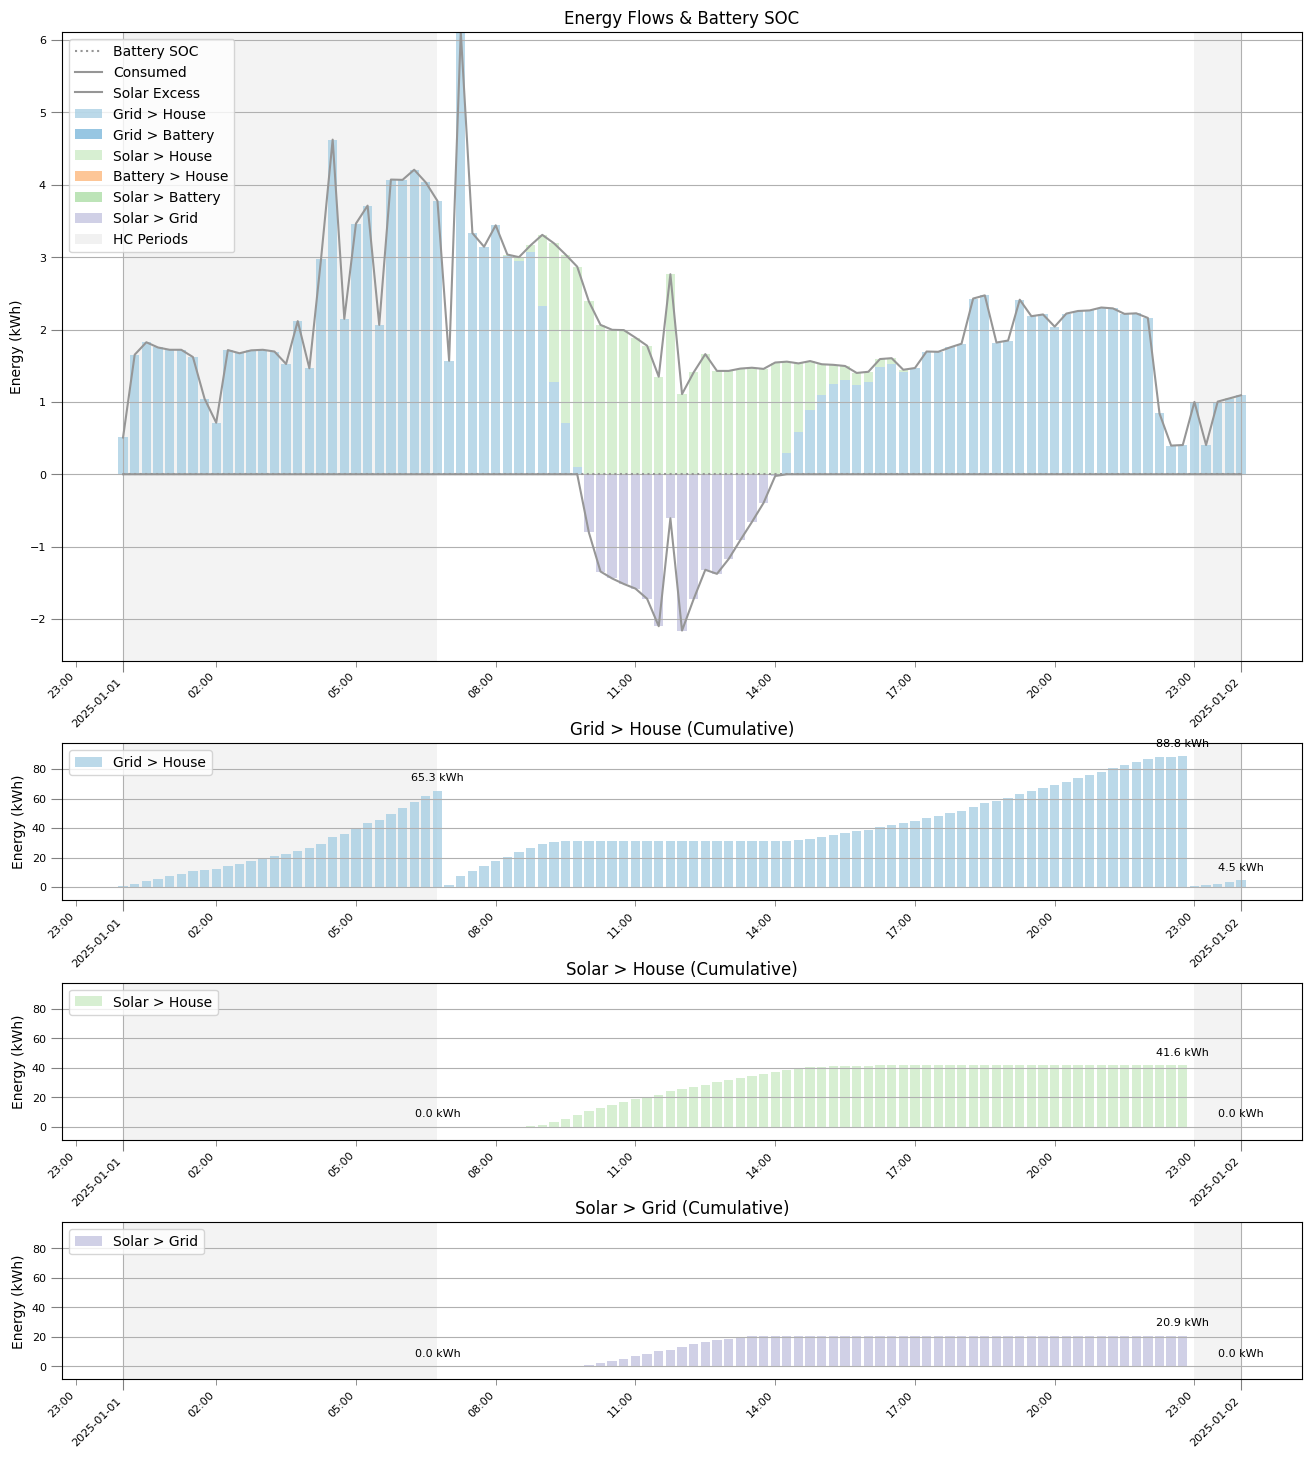

System Solar=9 kWc and Battery=10 kWh



/var/folders/ly/wb3q5mnj731fsq9lm72k717c0000gn/T/ipykernel_76875/3601772510.py:326: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/ly/wb3q5mnj731fsq9lm72k717c0000gn/T/ipykernel_76875/3601772510.py:326: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


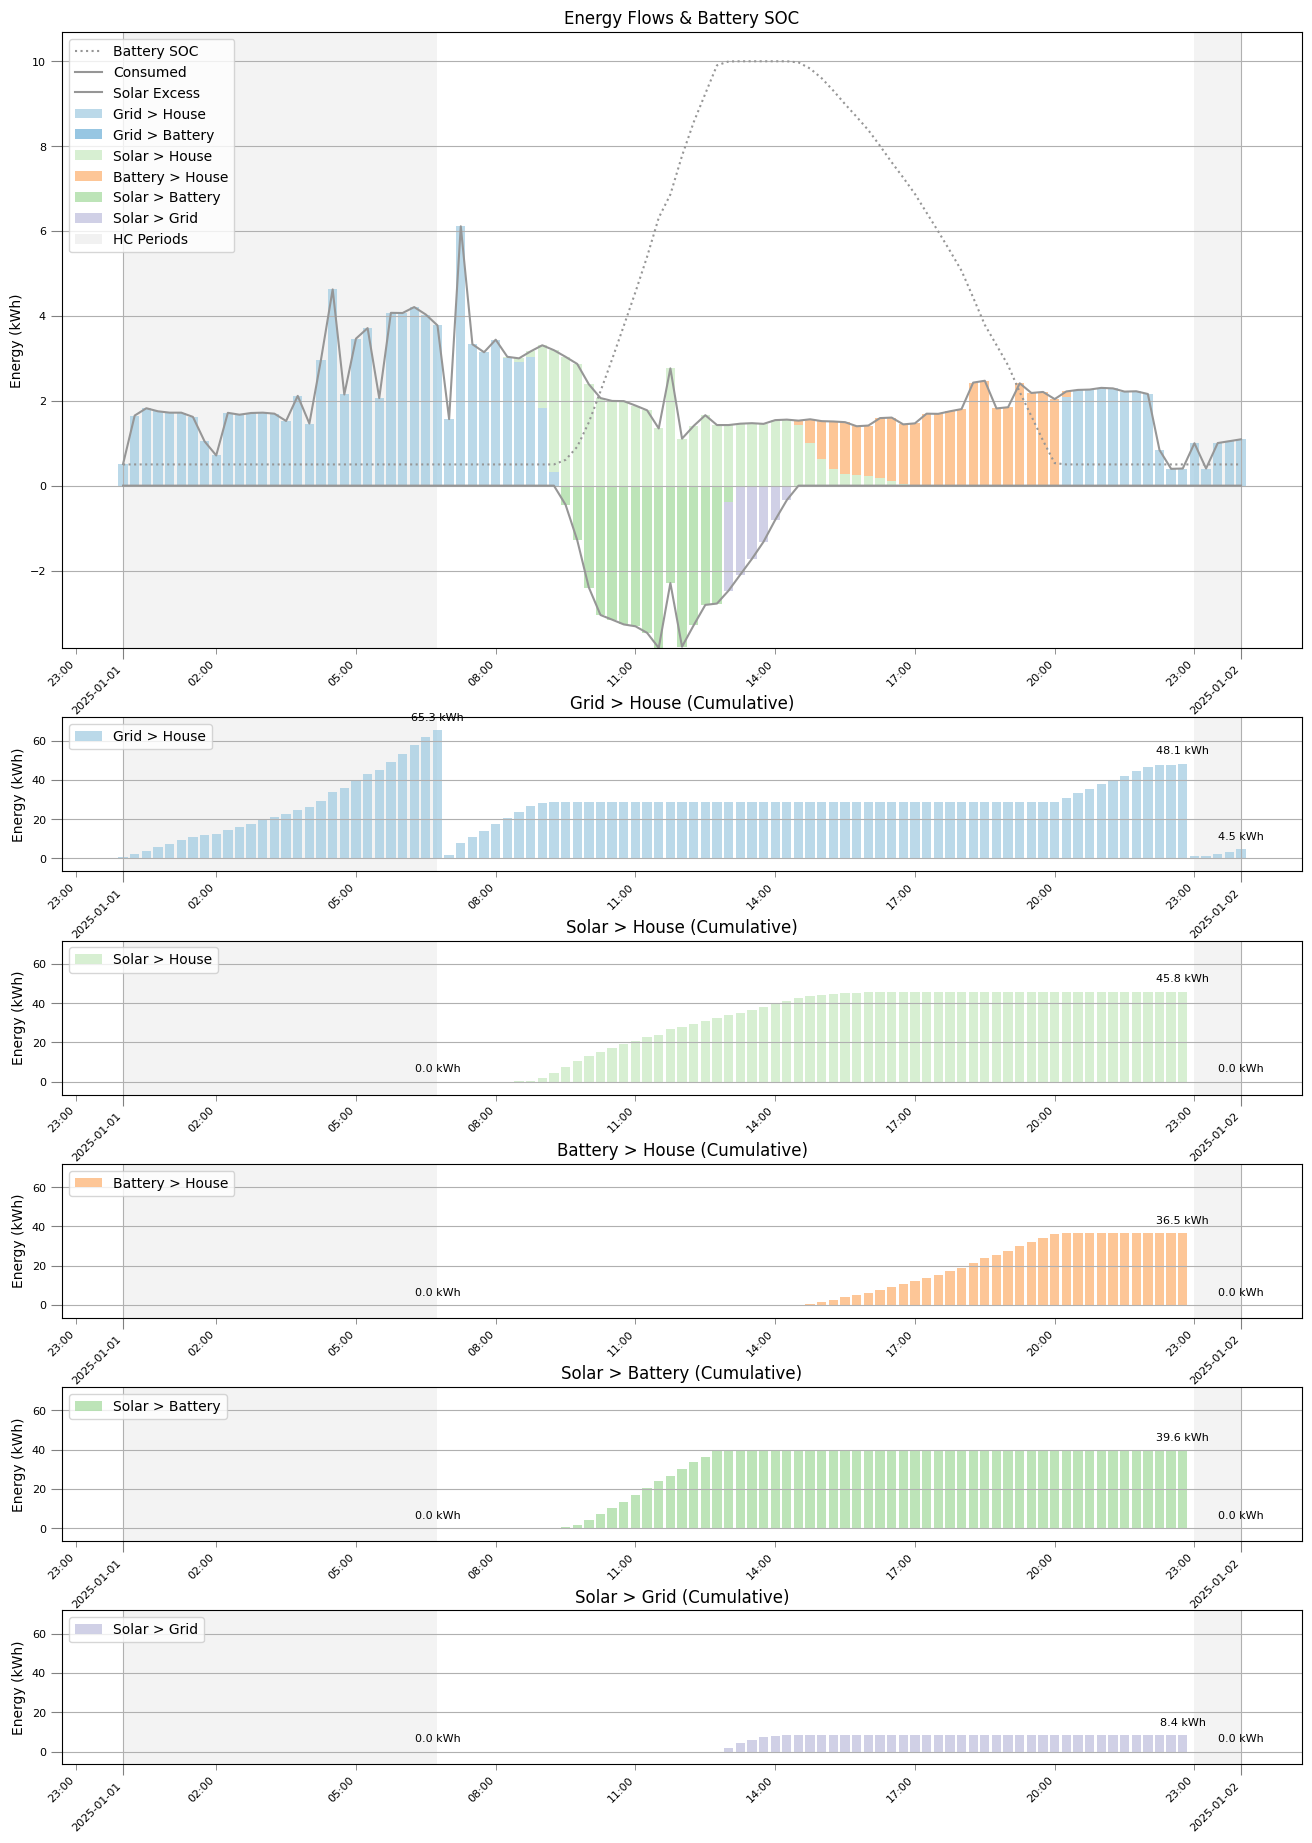

In [72]:
for start_date_text, end_date_text in periods:

    print(f'')
    print(f'Period {start_date_text} to {end_date_text}')
    print(f'')
    
    print(f'System Solar=6 kWc and Battery=0 kWh')
    print(f'')
    
    plot_battery_soc_chart_v2(
        raw_data_6_0,
        start_date_text,
        end_date_text,
        y_min=None,
        y_max=None,
        cumulative_metrics=None,
        reset_freq="HC/HP")
    
    print(f'System Solar=9 kWc and Battery=10 kWh')
    print(f'')
    
    plot_battery_soc_chart_v2(
        raw_data_9_10,
        start_date_text,
        end_date_text,
        y_min=None,
        y_max=None,
        cumulative_metrics=None,
        reset_freq="HC/HP")

    break